In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import data
import gpt 
from tqdm import tqdm, trange
import json 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'cuda': 
  print(torch.cuda.get_device_name()) 
else: 
  print(device) 

with open('config.json', 'r') as file: 
  config = json.load(file)

lr = config['lr']
bs = config['batch_size']

vocab_size, encode = data._init_data() 

NVIDIA GeForce RTX 3090


In [3]:
model = gpt.gpt_model(vocab_size=vocab_size).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')

28.873817 M parameters.


Iterations: 10000/10000: 100%|██████████| 10000/10000 [1:38:34<00:00,  1.69it/s, best_iter=5888, best_val_loss=0.958, loss=0.703, val_loss=1.01] 


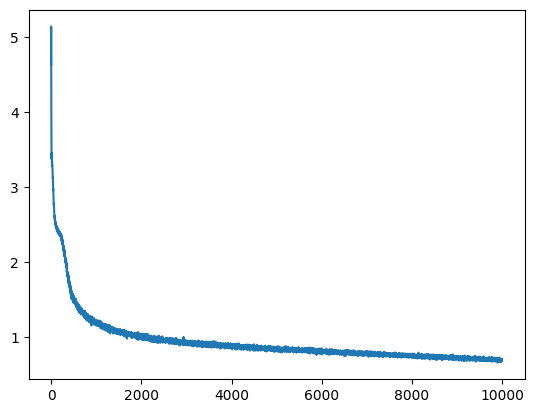

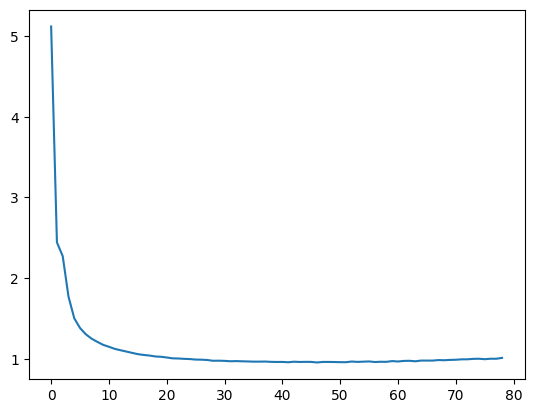

In [4]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

losses, val_losses, val_loss, best_val_loss, best_val_iter = list(), list(), 0, 100, 0

steps = 64 // bs 

max_iters = 10000
for iter in (loop := trange(max_iters)): 
	x, y = data.dataloader('train')
	
	logits = model(x.to(device))

	B, T, C = logits.shape 
	logits = logits.view(B*T, C)
	targets = y.view(B*T)
	loss = F.cross_entropy(logits, targets.to(device)) / steps
	losses.append(loss.item()*steps)
	loss.backward()
	if iter % steps == 0: 
		optimizer.step() 
		model.zero_grad()

	if iter % 128 == 0: 
		loss_dim = 100
		val_loss_tensor = torch.zeros((loss_dim))
		for j in range(loss_dim): 
			x, y = data.dataloader('val')
			with torch.no_grad(): 
				logits = model(x.to(device))

				B, T, C = logits.shape 
				logits = logits.view(B*T, C)
				targets = y.view(B*T)
				val_loss = F.cross_entropy(logits, targets.to(device)) 
			val_loss_tensor[j] = val_loss.item()
		val_losses.append(val_loss_tensor.mean().item())
		if val_losses[-1] < best_val_loss: 
			best_val_loss = val_losses[-1]
			best_val_iter = iter
			torch.save(model.state_dict(), f'models/best_performing.pth')

	# if iter % 512 == 0: 
	# 	torch.save(model.state_dict(), f'models/checkpoint_{iter}.pth')
	# 	x, y = data.dataloader('val')
	# 	with torch.no_grad(): 
	# 		generated = data.decode(x[0][-50:].tolist())
	# 		generated += data.decode(model.generate(x[0].unsqueeze(0).to(device), 50)[0, -50:].tolist())
	# 	with open(f'generations/{iter}.txt', 'w', encoding='utf-8') as file: 
	# 		file.write(generated)

	loop.set_description(f'Iterations: {iter+1}/{max_iters}')
	loop.set_postfix(loss=loss.item()*steps, val_loss=val_losses[-1], best_val_loss=best_val_loss, best_iter=best_val_iter)

plt.plot(losses)
plt.show()
plt.plot(val_losses) # 2.15, 6.09

In [6]:
# val_idx = list() 
# for idx, i in enumerate(val_losses): 
#   val_idx.append((idx, i))

In [7]:
# import pickle as pkl 

# with open('val_losses.pkl', 'wb') as file: 
#   pkl.dump(val_idx, file)

In [8]:
val_idx

NameError: name 'val_idx' is not defined

In [ ]:
# x, y = data.dataloader('val')

In [ ]:
# print(data.decode(x[0][-10:].tolist()))
# print('GENERATED')
# print(data.decode(model.generate(x[0].unsqueeze(0).to(device), 50)[0, -50:].tolist())) 

 you were my best friend, this is my sister
GENERATED
! My sister! My best friend and my sister! I-I cannot believe this!!
Chandler Bing: Look, we're not gonna throw it to New Year's with you.
Phoebe Buffay: You guys knew about this.
Chandler
